In [1]:
# !pip install openai

In [2]:
import operator
import random

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.metrics.pairwise import euclidean_distances
from openai import OpenAI

In [3]:
# Set the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Randomly sample 10% of the training set
train_size = len(trainset)
train_indices = random.sample(range(train_size), int(train_size * 1.0))
train_subset = Subset(trainset, train_indices)

# Randomly sample 10% of the test set
test_size = len(testset)
test_indices = random.sample(range(test_size), int(test_size * 1.0))
test_subset = Subset(testset, test_indices)

# Create data loaders for the subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


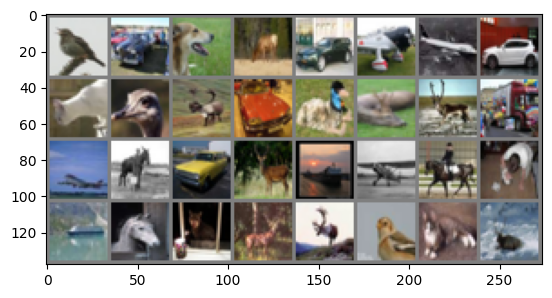

bird  car   dog   deer  car   plane plane car   cat   bird  deer  car   bird  deer  deer  truck plane horse car   deer  ship  plane horse dog   ship  horse cat   deer  deer  bird  cat   deer 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.optim as optim

# Simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Setup
import torch.nn.functional as F

n_labels_total = 3000
sampled_thus_far = 1000 # initial number of labeled samples
k = 500  # batch size for active learning

# Helper function to train the model
def train_model(net, trainloader, criterion, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Helper function to evaluate the model
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [11]:
set_seed(0)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 1, Loss: 2.3042720407247543
Epoch 2, Loss: 2.3037059903144836
Epoch 3, Loss: 2.3029895797371864
Epoch 4, Loss: 2.3018887042999268
Epoch 5, Loss: 2.301124982535839
Epoch 6, Loss: 2.301530845463276
Epoch 7, Loss: 2.3002180010080338
Epoch 8, Loss: 2.3002310171723366
Epoch 9, Loss: 2.299478217959404
Epoch 10, Loss: 2.2984778359532356
10.02
Epoch 1, Loss: 2.2994980964254825
Epoch 2, Loss: 2.2986357009157223
Epoch 3, Loss: 2.297941847050444
Epoch 4, Loss: 2.2970013821378665
Epoch 5, Loss: 2.296092195713774
Epoch 6, Loss: 2.294961371320359
Epoch 7, Loss: 2.2935725881698286
Epoch 8, Loss: 2.2918808054416737
Epoch 9, Loss: 2.2895877614934395
Epoch 10, Loss: 2.2868511930425117
10.79
Epoch 1, Loss: 2.281710000265212
Epoch 2, Loss: 2.274427266347976
Epoch 3, Loss: 2.263796181905837
Epoch 4, Loss: 2.2482493869842046
Epoch 5, Loss: 2.2241897091032965
Epoch 6, Loss: 2.1886650342789906
Epoch 7, Loss: 2.1368402904934354
Epoch 8, Loss: 2.0827017284574962
Epoch 9, Loss: 2.0432349613734653
Epoch 10,

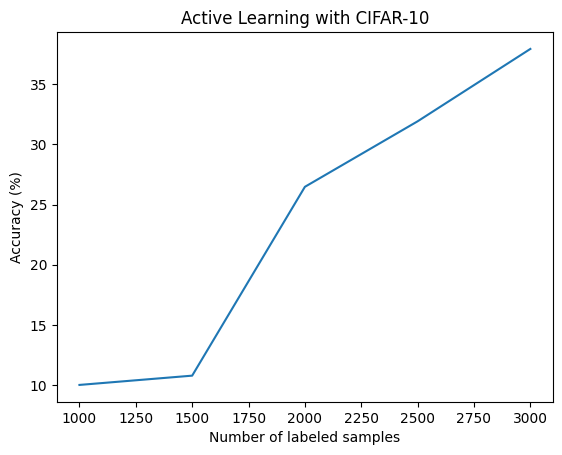

In [12]:
# Random

# n_labels_total = 3000
# sampled_thus_far = 1000 # initial number of labeled samples
# k = 200  # batch size for active learning

# Initialize pool indices and initial training indices
pool_indices = list(range(len(trainset)))
cur_train_indices = pool_indices[:sampled_thus_far]
pool_indices = pool_indices[sampled_thus_far:]

# Initial training set and loader
trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                          batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model initially
train_model(net, trainloader, criterion, optimizer, epochs=10)
initial_score = evaluate_model(net, testloader)
print(initial_score)

num_labels = [sampled_thus_far]  # x-axis for learning curve
scores = [initial_score]  # y-axis for learning curve

while sampled_thus_far < n_labels_total:
    cur_sample = random.sample(pool_indices, k)
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)

    # Update trainloader with new data
    trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                              batch_size=batch_size, shuffle=True, num_workers=2)

    # Train and evaluate the model
    train_model(net, trainloader, criterion, optimizer, epochs=10)
    score = evaluate_model(net, testloader)

    num_labels.append(len(cur_train_indices))
    scores.append(score)
    sampled_thus_far += k
    print(score)

# Plot learning curve
plt.plot(num_labels, scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

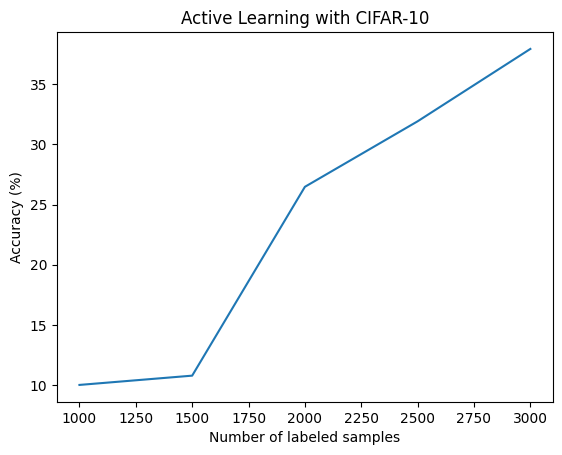

In [13]:
# Plot learning curve
plt.plot(num_labels, scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

In [17]:
import torch.nn.functional as F

n_labels_total = 3000
sampled_thus_far = 1000 # initial number of labeled samples
k = 500  # batch size for active learning

# Helper function to train the model
def train_model(net, trainloader, criterion, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Helper function to evaluate the model
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [18]:
set_seed(0)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 1, Loss: 2.3042720407247543
Epoch 2, Loss: 2.3037059903144836
Epoch 3, Loss: 2.3029895797371864
Epoch 4, Loss: 2.3018887042999268
Epoch 5, Loss: 2.301124982535839
Epoch 6, Loss: 2.301530845463276
Epoch 7, Loss: 2.3002180010080338
Epoch 8, Loss: 2.3002310171723366
Epoch 9, Loss: 2.299478217959404
Epoch 10, Loss: 2.2984778359532356
10.02
Epoch 1, Loss: 2.299577276757423
Epoch 2, Loss: 2.2990154763485524
Epoch 3, Loss: 2.298169785357536
Epoch 4, Loss: 2.2973221870178873
Epoch 5, Loss: 2.2964520302224667
Epoch 6, Loss: 2.2951912321942918
Epoch 7, Loss: 2.293950806272791
Epoch 8, Loss: 2.292223073066549
Epoch 9, Loss: 2.290098438871668
Epoch 10, Loss: 2.2875203629757497
13.63
Epoch 1, Loss: 2.285089576055133
Epoch 2, Loss: 2.2792902938903326
Epoch 3, Loss: 2.271178026047964
Epoch 4, Loss: 2.2591128197927324
Epoch 5, Loss: 2.240310922501579
Epoch 6, Loss: 2.207867134185064
Epoch 7, Loss: 2.161338208213685
Epoch 8, Loss: 2.1035296784506903
Epoch 9, Loss: 2.0615722300514343
Epoch 10, Los

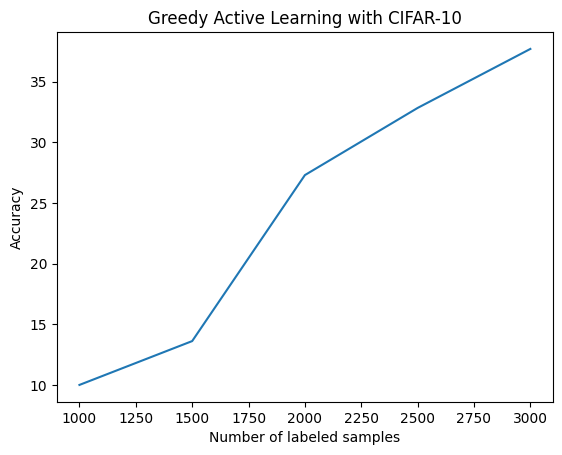

In [19]:
# Greedy based on confidence

# n_labels_total = 50
# sampled_thus_far = 10  # initial number of labeled samples
# k = 20  # batch size for active learning

# Initialize pool indices and initial training indices
pool_indices = list(range(len(trainset)))
cur_train_indices = pool_indices[:sampled_thus_far]
pool_indices = pool_indices[sampled_thus_far:]

# # Helper function to train the model
# def train_model(net, trainloader, criterion, optimizer, epochs=1):
#     net.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in trainloader:
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# # Helper function to evaluate the model
# def evaluate_model(net, testloader):
#     net.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             outputs = net(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return 100 * correct / total

# Initial training set and loader
trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                          batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model initially
train_model(net, trainloader, criterion, optimizer, epochs=10)
initial_score = evaluate_model(net, testloader)
print(initial_score)

num_labels = [sampled_thus_far]  # x-axis for learning curve
active_scores = [initial_score]  # y-axis for learning curve

while sampled_thus_far < n_labels_total:
    # predict all probabilities
    pool_subset = Subset(trainset, pool_indices)
    pool_loader = torch.utils.data.DataLoader(pool_subset, batch_size=batch_size, shuffle=True, num_workers=2)

    indices_to_probs = {}
    with torch.no_grad():
        counter = 0
        for batch_idx, (inputs, _) in enumerate(pool_loader):
            counter += 1
            if counter == 10000:
                break
            batch_start_idx = batch_idx * batch_size
            batch_indices = pool_indices[batch_start_idx:batch_start_idx + batch_size]

            outputs = net(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probs, 1)

            for i, idx in enumerate(batch_indices):
                uncertainty = abs(max_probs[i].item())
                indices_to_probs[idx] = uncertainty

    # rank instances!
    sorted_indices = sorted(indices_to_probs, key=indices_to_probs.get, reverse=False)
    # take top k
    cur_sample = sorted_indices[:k]

    # remove these so we don't sample again! and
    # add to train/pool sample
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)

    # Update trainloader with new data
    trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                              batch_size=batch_size, shuffle=True, num_workers=2)

    # Train and evaluate the model
    train_model(net, trainloader, criterion, optimizer, epochs=10)
    score = evaluate_model(net, testloader)

    num_labels.append(len(cur_train_indices))
    active_scores.append(score)
    sampled_thus_far += k
    print(score)

# Plot learning curve
plt.plot(num_labels, active_scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy')
plt.title('Greedy Active Learning with CIFAR-10')
plt.show()

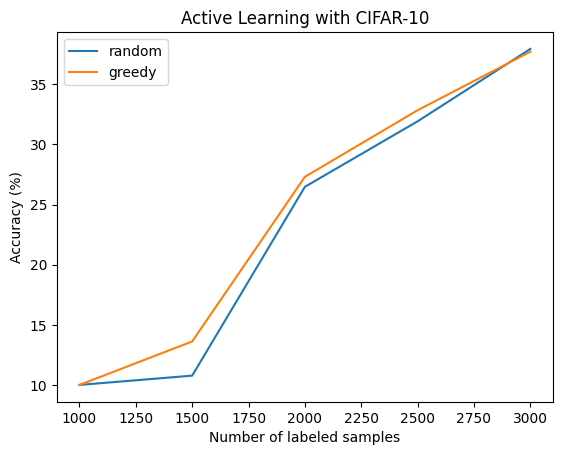

In [20]:
# plot together
plt.plot(num_labels, scores, label='random')
plt.plot(num_labels, active_scores, label='greedy')
plt.legend(loc="upper left");
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

In [21]:
# client = OpenAI(api_key="api_key")

In [22]:
# from transformers import CLIPProcessor, CLIPModel
# from PIL import Image

In [23]:
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# # Load the processor
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [24]:
# inputs

In [25]:
# # # Load an example image
# img = Image.open("writing.jpg")
# # # Preprocess the image using the processor
# inputs = processor(images=img, return_tensors="pt", padding=True)
# # Geneprate the embeddings using the model
# outputs = model.get_image_features(**inputs)

In [26]:
# inputs = processor(images=img, return_tensors="pt", padding=True)
# outputs = model.get_image_features(**inputs)

In [27]:
# outputs.shape

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 4, 4)
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output: (3, 32, 32)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_embeddings(self, x):
        return nn.Flatten()(self.encoder(x))

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

subset = Subset(trainset, range(100))
loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)

num_epochs = 20

for epoch in range(num_epochs):
    for data in loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")

Epoch [1/20], Loss: 0.1746
Epoch [2/20], Loss: 0.2562
Epoch [3/20], Loss: 0.1625
Epoch [4/20], Loss: 0.1207
Epoch [5/20], Loss: 0.1158
Epoch [6/20], Loss: 0.1207
Epoch [7/20], Loss: 0.0892
Epoch [8/20], Loss: 0.0832
Epoch [9/20], Loss: 0.0878
Epoch [10/20], Loss: 0.0812
Epoch [11/20], Loss: 0.0589
Epoch [12/20], Loss: 0.0599
Epoch [13/20], Loss: 0.0731
Epoch [14/20], Loss: 0.0502
Epoch [15/20], Loss: 0.0604
Epoch [16/20], Loss: 0.0544
Epoch [17/20], Loss: 0.0633
Epoch [18/20], Loss: 0.0505
Epoch [19/20], Loss: 0.0653
Epoch [20/20], Loss: 0.0376
Training finished.


In [34]:
import torch.nn.functional as F

n_labels_total = 3000
sampled_thus_far = 1000 # initial number of labeled samples
k = 500  # batch size for active learning

# Helper function to train the model
def train_model(net, trainloader, criterion, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Helper function to evaluate the model
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [35]:
set_seed(0)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 1, Loss: 2.3042720407247543
Epoch 2, Loss: 2.3037059903144836
Epoch 3, Loss: 2.3029895797371864
Epoch 4, Loss: 2.3018887042999268
Epoch 5, Loss: 2.301124982535839
Epoch 6, Loss: 2.301530845463276
Epoch 7, Loss: 2.3002180010080338
Epoch 8, Loss: 2.3002310171723366
Epoch 9, Loss: 2.299478217959404
Epoch 10, Loss: 2.2984778359532356
10.02
0
50
100
150
200
250
Epoch 1, Loss: 2.2999931396322046
Epoch 2, Loss: 2.299377294296914
Epoch 3, Loss: 2.2986527351622885
Epoch 4, Loss: 2.297795645734097
Epoch 5, Loss: 2.2968750050727356
Epoch 6, Loss: 2.2957266543773893
Epoch 7, Loss: 2.2944918084651866
Epoch 8, Loss: 2.292603183299937
Epoch 9, Loss: 2.290492722328673
Epoch 10, Loss: 2.287880329375571
11.22
0
50
100
150
200
250
Epoch 1, Loss: 2.284253922719804
Epoch 2, Loss: 2.27774977684021
Epoch 3, Loss: 2.2684958851526655
Epoch 4, Loss: 2.254990479302785
Epoch 5, Loss: 2.2332549246530684
Epoch 6, Loss: 2.1988285079834955
Epoch 7, Loss: 2.1462931557307168
Epoch 8, Loss: 2.092070944725521
Epoch

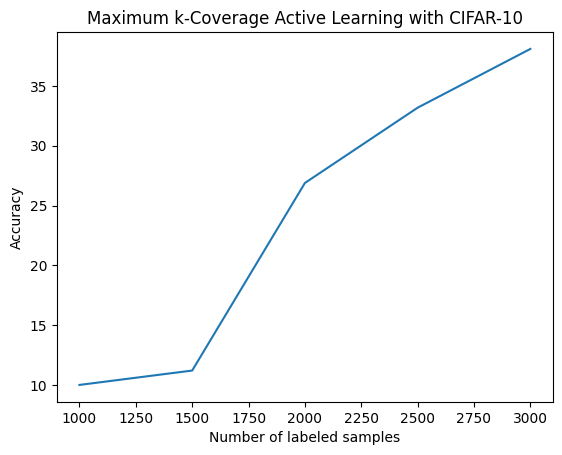

In [36]:
# Initialize pool indices and initial training indices
pool_indices = list(range(min(len(trainset),10000)))
cur_train_indices = pool_indices[:sampled_thus_far]
pool_indices = pool_indices[sampled_thus_far:]

# Initial training set and loader
trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                         batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model initially
train_model(net, trainloader, criterion, optimizer, epochs=10)
initial_score = evaluate_model(net, testloader)
print(initial_score)

num_labels = [sampled_thus_far]  # x-axis for learning curve
cover_scores = [initial_score]  # y-axis for learning curve

while sampled_thus_far < n_labels_total:
    # Get embeddings for the pool set
    pool_subset = Subset(trainset, pool_indices)
    pool_loader = torch.utils.data.DataLoader(pool_subset, batch_size=batch_size, shuffle=True, num_workers=2)

    embeddings = []
    indices = []

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(pool_loader):
            outputs = model.get_embeddings(inputs)
            # inputs = inputs - inputs.min()
            # inputs = inputs / inputs.max()
            # inputs = processor(images=inputs, return_tensors="pt", padding=True)
            # outputs = model.get_image_features(**inputs)
            # print(inputs)
            embeddings.append(outputs.cpu().numpy())
            batch_start_idx = batch_idx * batch_size
            batch_indices = pool_indices[batch_start_idx:batch_start_idx + batch_size]
            indices.extend(batch_indices)
            if batch_idx % 50 == 0:
              print(batch_idx)

    embeddings = np.vstack(embeddings)

    # Calculate distance matrix
    distances = euclidean_distances(embeddings)
    threshold = np.percentile(distances, 1)

    # Find the example that covers the most others within a threshold
    # threshold = 1.0  # You can adjust this threshold based on your requirements
    cover_counts = (distances < threshold).sum(axis=1)

    # Rank by cover counts
    sorted_indices = np.argsort(-cover_counts)  # Descending order
    cur_sample = [indices[i] for i in sorted_indices[:k]]

    # Remove these from pool and add to train set
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)

    # Update trainloader with new data
    trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                             batch_size=batch_size, shuffle=True, num_workers=2)

    # Train and evaluate the model
    train_model(net, trainloader, criterion, optimizer, epochs=10)
    score = evaluate_model(net, testloader)

    num_labels.append(len(cur_train_indices))
    cover_scores.append(score)
    sampled_thus_far += k
    print(score)

# Plot learning curve
plt.plot(num_labels, cover_scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy')
plt.title('Maximum k-Coverage Active Learning with CIFAR-10')
plt.show()

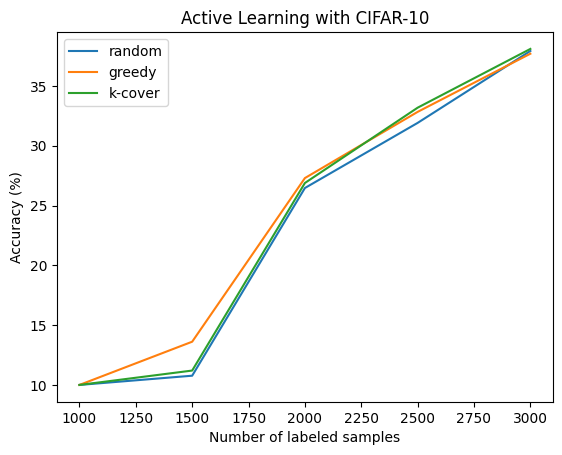

In [37]:
# plot together
plt.plot(num_labels, scores, label='random')
plt.plot(num_labels, active_scores, label='greedy')
plt.plot(num_labels, cover_scores, label='k-cover')
plt.legend(loc="upper left");
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

In [33]:
plt.imshow(distances / distances.max())
plt.colorbar()
plt.show()